### From previous meeting


Word2vec improvements [Pengtai]

  Word2vec maximum word length more than 15! 
  Remove duplicates before prediction 
  Preprocessing combinations 
  Sklearn version 
  Update the performance 


## imports

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers as ppb # pytorch transformers

import gzip
import gensim
from gensim import models
import lightgbm as lgb
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from text_processing import text_processing

In [5]:
from platform import python_version
from IPython.display import display, HTML
print('Python', python_version())
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 95%; }
    div#header-container      { width: 95%; }
    div#maintoolbar-container { width: 95%; }""
</style>
"""))

Python 3.7.6


In [6]:
model = models.KeyedVectors.load_word2vec_format(
    './GoogleNews-vectors-negative300.bin', binary=True)

## functions

In [7]:
def get_text_token(text):
    # Tokenize the sentence
    tokenized=text.apply((lambda x: gensim.utils.simple_preprocess(x)))

    # Filter out words not in trained corpus, and add a '0' if setence is empty
    def filter_vocab(lst):
        result = ['0']
        if len(lst):
            result = [i for i in lst if i in model.vocab] 
        return result

    tokenized=tokenized.apply(lambda x: filter_vocab(x))
    return tokenized

In [8]:
def get_embedding(textToken):
    
    embedding=textToken.apply(lambda x: model[x])
    embedding=np.array(list(embedding.apply(lambda x: sum(x)/len(x))))
    return embedding

In [9]:
def get_embed_features(text):
    # Tokenize the sentence
    tokenized=text.apply((lambda x: gensim.utils.simple_preprocess(x)))

    # Filter out words not in trained corpus, and add a '0' if setence is empty
    def filter_vocab(lst):
        result = ['0']
        if len(lst):
            result = [i for i in lst if i in model.vocab] 
        return result

    tokenized=tokenized.apply(lambda x: filter_vocab(x)) 
    embedding=tokenized.apply(lambda x: model[x])
    embedding=np.array(list(embedding.apply(lambda x: sum(x)/len(x))))
    return embedding

In [10]:
def get_results(model, test_features, test_label, thresh = 0.5):
    test_pred = (model.predict_proba(test_features)[:,1] >= thresh).astype(bool)
    print(classification_report(test_label, test_pred, digits=5))
    return None

## investigations

### 1. min/max_len parameter

In [115]:
tokenized_2vec= gensim.utils.simple_preprocess('''account hacked ?. i have accounts on bitstamp bittrex and binance . 
                                                this morning i tried to access all 3 and all 3 said that my password was incorrect . 
                                                i reset all 3 and all my funds are there , but it's obviously kind of weird that i 
                                                couldn't access all my accounts at once . is it possible that someone tried to access 
                                                my account many times with incorrect attempts and so it got blocked ? \n\n-the passwords 
                                                are different but similar if someone figures out the system ( only a few variations in 
                                                the password ) \n-i didn't get any warning emails from any of the exchanges''', min_len=3)

In [116]:
tokenized_2vec

['account',
 'hacked',
 'have',
 'accounts',
 'bitstamp',
 'bittrex',
 'and',
 'binance',
 'this',
 'morning',
 'tried',
 'access',
 'all',
 'and',
 'all',
 'said',
 'that',
 'password',
 'was',
 'incorrect',
 'reset',
 'all',
 'and',
 'all',
 'funds',
 'are',
 'there',
 'but',
 'obviously',
 'kind',
 'weird',
 'that',
 'couldn',
 'access',
 'all',
 'accounts',
 'once',
 'possible',
 'that',
 'someone',
 'tried',
 'access',
 'account',
 'many',
 'times',
 'with',
 'incorrect',
 'attempts',
 'and',
 'got',
 'blocked',
 'the',
 'passwords',
 'are',
 'different',
 'but',
 'similar',
 'someone',
 'figures',
 'out',
 'the',
 'system',
 'only',
 'few',
 'variations',
 'the',
 'password',
 'didn',
 'get',
 'any',
 'warning',
 'emails',
 'from',
 'any',
 'the',
 'exchanges']

In [245]:
tokenized_2vec= gensim.utils.simple_preprocess('''account hacked ?. i have accounts on bitstamp bittrex and binance . 
                                                this morning i tried to access all 3 and all 3 said that my Password was incorrect . 
                                                i reset all 3 and all my funds are there , but it's obviously kind of weird that i 
                                                couldn't access all my accounts at once . is it possible that someone tried to access 
                                                my account many times with incorrect attempts and so it got blocked ? \n\n-the passwords 
                                                are different but similar if someone figures out the system ( only a few variations in 
                                                the password ) \n-i didn't get any warning emails from any of the exchanges''', min_len=5)

In [246]:
tokenized_2vec

['account',
 'hacked',
 'accounts',
 'bitstamp',
 'bittrex',
 'binance',
 'morning',
 'tried',
 'access',
 'password',
 'incorrect',
 'reset',
 'funds',
 'there',
 'obviously',
 'weird',
 'couldn',
 'access',
 'accounts',
 'possible',
 'someone',
 'tried',
 'access',
 'account',
 'times',
 'incorrect',
 'attempts',
 'blocked',
 'passwords',
 'different',
 'similar',
 'someone',
 'figures',
 'system',
 'variations',
 'password',
 'warning',
 'emails',
 'exchanges']

### 2. entity dependency

In [124]:
def filter_vocab(lst):
    result = ['0']
    if len(lst):
        result = [i for i in lst if i in model.vocab] 
    return result

In [125]:
filter_vocab(tokenized_2vec)

['account',
 'hacked',
 'accounts',
 'morning',
 'tried',
 'access',
 'password',
 'incorrect',
 'reset',
 'funds',
 'there',
 'obviously',
 'weird',
 'couldn',
 'access',
 'accounts',
 'possible',
 'someone',
 'tried',
 'access',
 'account',
 'times',
 'incorrect',
 'attempts',
 'blocked',
 'passwords',
 'different',
 'similar',
 'someone',
 'figures',
 'system',
 'variations',
 'password',
 'warning',
 'emails',
 'exchanges']

### 3. length limit

In [128]:
tokenized_2vec= gensim.utils.simple_preprocess('''account hacked ?. i have accounts on bitstamp bittrex and binance . 
                                                this morning i tried to access all 3 and all 3 said that my password was incorrect . 
                                                i reset all 3 and all my funds are there , but obviously kind of weird that i 
                                                access all my accounts at once . is it possible that someone tried to access 
                                                my account many times with incorrect attempts and so it got blocked ? \n\n-the passwords 
                                                are different but similar if someone figures out the system ( only a few variations in 
                                                the password ) \n-i get any warning emails from any of the exchanges''')

In [129]:
model[filter_vocab(tokenized_2vec)].shape

(79, 300)

In [130]:
tokenized_2vec= gensim.utils.simple_preprocess('''hello, it's me''')

In [131]:
model[filter_vocab(tokenized_2vec)].shape

(3, 300)

## improvement attempts

### 1. get embedding from column max instead of mean (maxpooling)

In [22]:
def get_embed_features_max(text):
    # Tokenize the sentence
    tokenized_2vec=text.apply((lambda x: gensim.utils.simple_preprocess(x)))

    # Filter out words not in trained corpus, and add a '0' if setence is empty
    def filter_vocab(lst):
        result = ['0']
        if len(lst):
            result = [i for i in lst if i in model.vocab] 
        return result

    tokenized_2vec=tokenized_2vec.apply(lambda x: filter_vocab(x))
    embedding=tokenized_2vec.apply(lambda x: model[x])
    
    # get the max of each column from the embedding matrix
    features_2vec=np.array(list(embedding.apply(lambda x: np.array(x).max(axis=0))))   
    return features_2vec

In [23]:
train_features_max = get_embed_features_max(all_train['text'])

In [25]:
from sklearn.calibration import CalibratedClassifierCV

In [26]:
svc_new = SVC()
svc_new = CalibratedClassifierCV(svc_new) 
svc_new.fit(train_features_max, all_train['label'])

CalibratedClassifierCV(base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

In [29]:
news_features_max = get_embed_features_max(news['text'])

In [30]:
# svm new max embedding
get_results(svc_new, news_features_max, news['label'])

              precision    recall  f1-score   support

           0    0.85343   0.98712   0.91542       466
           1    0.86667   0.33051   0.47853       118

    accuracy                        0.85445       584
   macro avg    0.86005   0.65882   0.69698       584
weighted avg    0.85611   0.85445   0.82715       584



In [138]:
# prev results
get_results(svc, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86965   0.95923   0.91224       466
           1    0.72857   0.43220   0.54255       118

    accuracy                        0.85274       584
   macro avg    0.79911   0.69572   0.72740       584
weighted avg    0.84114   0.85274   0.83755       584



### 2. use lightGBM as the binary classifier

In [146]:
clf = lgb.LGBMClassifier()

In [147]:
train_features, val_features, train_y, val_y = train_test_split(train_features, all_train['label'], random_state=4222)

In [148]:
gbm = clf.fit(X=train_features, 
              y=train_y,
              eval_set=[(val_features, val_y)],
              eval_metric=['auc', 'binary_logloss'],
              early_stopping_rounds=50, 
              verbose=True)

[1]	valid_0's auc: 0.792534	valid_0's binary_logloss: 0.589081
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.812303	valid_0's binary_logloss: 0.562837
[3]	valid_0's auc: 0.811909	valid_0's binary_logloss: 0.543352
[4]	valid_0's auc: 0.816088	valid_0's binary_logloss: 0.525586
[5]	valid_0's auc: 0.818476	valid_0's binary_logloss: 0.511651
[6]	valid_0's auc: 0.820551	valid_0's binary_logloss: 0.499509
[7]	valid_0's auc: 0.823605	valid_0's binary_logloss: 0.488807
[8]	valid_0's auc: 0.829781	valid_0's binary_logloss: 0.478446
[9]	valid_0's auc: 0.834591	valid_0's binary_logloss: 0.468999
[10]	valid_0's auc: 0.835823	valid_0's binary_logloss: 0.462119
[11]	valid_0's auc: 0.841548	valid_0's binary_logloss: 0.453749
[12]	valid_0's auc: 0.844061	valid_0's binary_logloss: 0.447497
[13]	valid_0's auc: 0.844749	valid_0's binary_logloss: 0.442022
[14]	valid_0's auc: 0.844427	valid_0's binary_logloss: 0.438363
[15]	valid_0's auc: 0.847062	valid_0's binary_loglos

In [149]:
# lightGBM
get_results(gbm, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86590   0.96996   0.91498       466
           1    0.77419   0.40678   0.53333       118

    accuracy                        0.85616       584
   macro avg    0.82005   0.68837   0.72416       584
weighted avg    0.84737   0.85616   0.83787       584



In [150]:
# prev results svm
get_results(svc, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86965   0.95923   0.91224       466
           1    0.72857   0.43220   0.54255       118

    accuracy                        0.85274       584
   macro avg    0.79911   0.69572   0.72740       584
weighted avg    0.84114   0.85274   0.83755       584



### 3. use a different theshold 

In [158]:
actual = news['label']
pred = gbm.predict_proba(news_features)[:,1]

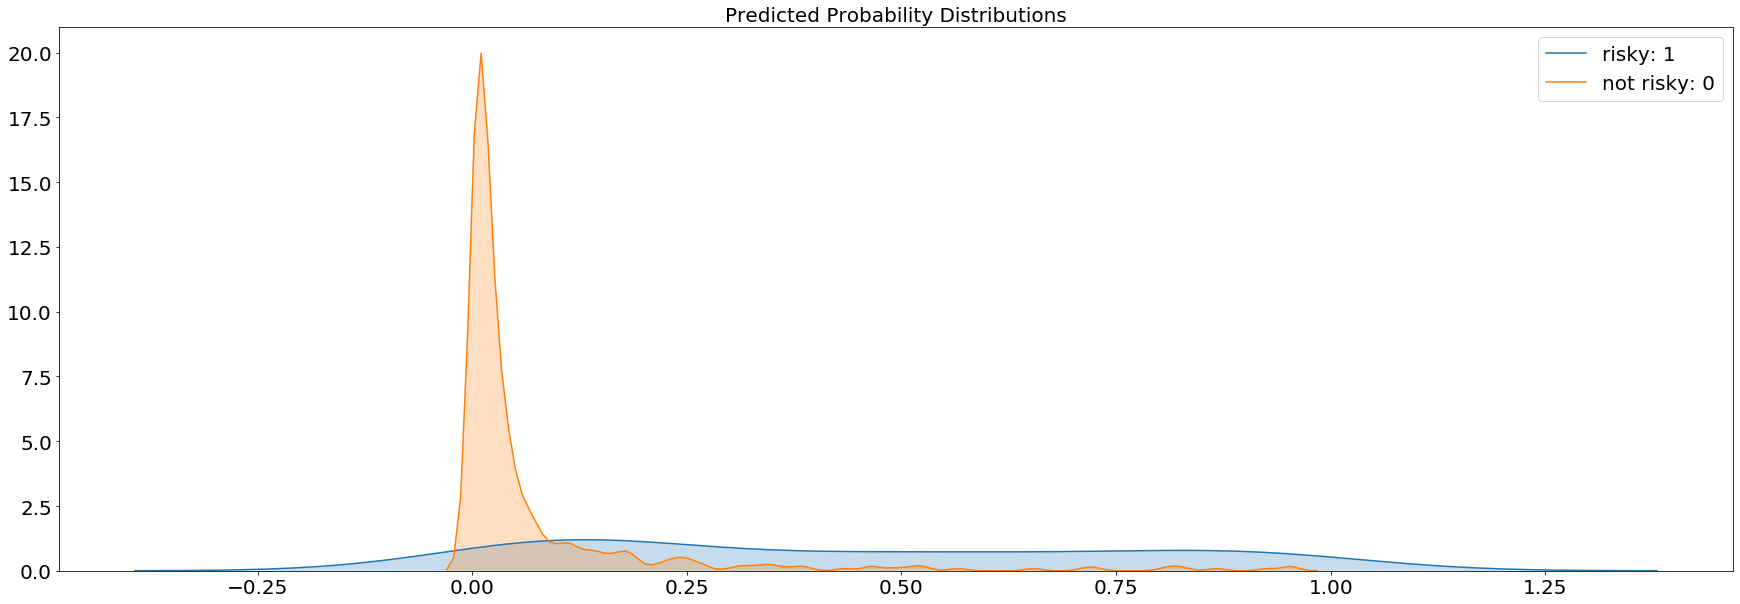

In [169]:
test_1_predicted = pred[actual==1]
test_0_predicted = pred[actual==0]

plt.figure(figsize = (30,10))
ax = sns.kdeplot(test_1_predicted, shade=True, label='risky: 1')
ax = sns.kdeplot(test_0_predicted, shade=True, label='not risky: 0')

plt.legend(prop={'size': 20})
plt.title("Predicted Probability Distributions", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

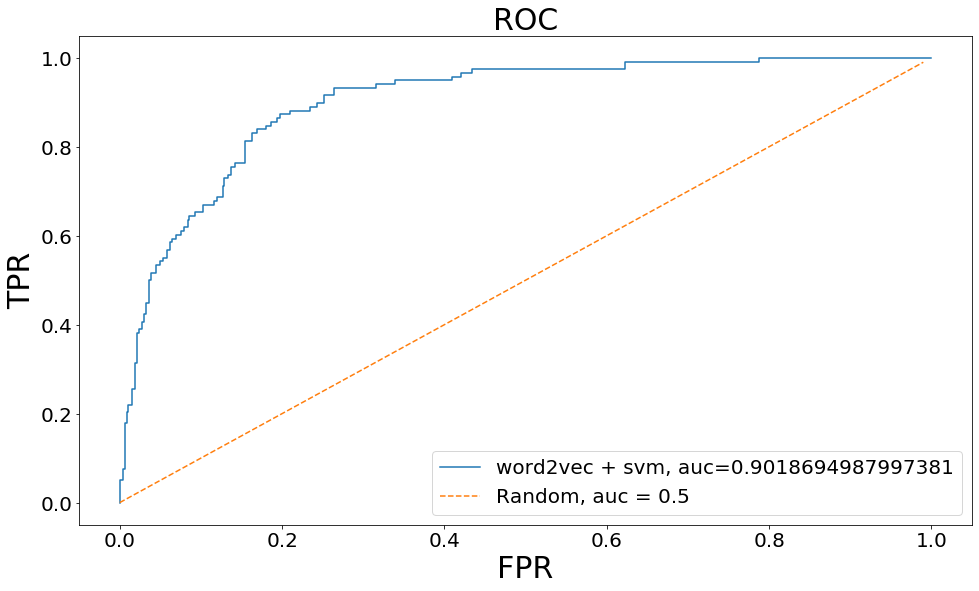

In [172]:
plt.figure(figsize=(16,9))

fpr, tpr, thresh = metrics.roc_curve(actual, pred)
auc = metrics.roc_auc_score(actual, pred)
plt.plot(fpr,tpr, label="word2vec + svm, auc="+str(auc))
plt.plot([i/100 for i in range(0,100)], [i/100 for i in range(0,100)], label='Random, auc = 0.5', linestyle = 'dashed')
plt.title("ROC", fontsize=30)
plt.xlabel("FPR", fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('TPR', fontsize=30)
plt.yticks(fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.show()

In [173]:
# performance summary acorss thresholds
table = pd.DataFrame(
        columns=['Thresh','P0', 'P1', 'R0', 'R1', 'F0', 'F1', 'Accuracy', 'AUC', 'TPR', 'FPR'])

threshold = 0.05 # update the optimum threshold 
while (threshold < 0.95):
    predicted_choice = (pred >= threshold).astype(int)
    predicted_choice = predicted_choice.tolist()
    pred_confusion_matrix = metrics.confusion_matrix(actual, predicted_choice)
    all_sum = pred_confusion_matrix.sum()
    tn, fp, fn, tp = pred_confusion_matrix.ravel()
    auc = metrics.roc_auc_score(actual, pred)
    p1 = tp / (tp + fp)
    p0 = tn / (tn + fn)
    r1 = tp / (tp + fn)
    r0 = tn / (tn + fp)
    f1 = 2 * ((p1 * r1) / (p1 + r1))
    f0 = 2 * ((p0 * r0) / (p0 + r0))
    a = ((tp + tn) / (fp + fn + tn + tp))
    tpr = tp * 1.0 / (tp + fn)
    fpr = fp * 1.0 / (fp + tn)
    tpr_minus_fpr = tpr - fpr
    p1_plus_r1 = p1 + r1
    distance = np.sqrt((1 - tpr) ** 2 + (0 - fpr) ** 2)
    table = table.append({'Thresh':threshold,'P0': p0,
                          'P1': p1, 'R0': r0, 'R1': r1, 'F0': f0, 'F1': f1,
                          'Accuracy': a, 'AUC': auc, 'TPR': tpr, 'FPR': fpr, 'Distance to (0,1) of ROC':distance, 
                          'TPR-FPR':tpr_minus_fpr},
                         ignore_index=True)
    threshold += 0.05
    
table.sort_values(by='F1', ascending=False) #rank by F1

,Thresh,P0,P1,R0,R1,F0,F1,Accuracy,AUC,TPR,FPR,"Distance to (0,1) of ROC",TPR-FPR
1,0.10,0.948905,0.560694,0.836910,0.822034,0.889396,0.666667,0.833904,0.901869,0.822034,0.163090,0.241392,0.658944
3,0.20,0.908316,0.652174,0.914163,0.635593,0.911230,0.643777,0.857877,0.901869,0.635593,0.085837,0.374380,0.549756
4,0.25,0.900826,0.700000,0.935622,0.593220,0.917895,0.642202,0.866438,0.901869,0.593220,0.064378,0.411842,0.528843
2,0.15,0.915556,0.597015,0.884120,0.677966,0.899563,0.634921,0.842466,0.901869,0.677966,0.115880,0.342248,0.562086
0,0.05,0.972067,0.477876,0.746781,0.915254,0.844660,0.627907,0.780822,0.901869,0.915254,0.253219,0.267024,0.662035
6,0.35,0.890000,0.750000,0.954936,0.533898,0.921325,0.623762,0.869863,0.901869,0.533898,0.045064,0.468275,0.488834
5,0.30,0.892276,0.706522,0.942060,0.550847,0.916493,0.619048,0.863014,0.901869,0.550847,0.057940,0.452874,0.492908
7,0.40,0.885375,0.769231,0.961373,0.508475,0.921811,0.612245,0.869863,0.901869,0.508475,0.038627,0.493041,0.469848
8,0.45,0.878669,0.767123,0.963519,0.474576,0.919140,0.586387,0.864726,0.901869,0.474576,0.036481,0.526689,0.438096
9,0.50,0.865900,0.774194,0.969957,0.406780,0.914980,0.533333,0.856164,0.901869,0.406780,0.030043,0.593981,0.376737


* Can choose 0.25 as the threshold

In [174]:
# test for other datasets

def get_results_new_threshold(model, test_features, test_label):
    test_pred = (model.predict_proba(test_features)[:,1] >= 0.25).astype(bool)
    print(classification_report(test_label, test_pred, digits=5))
    return None

In [175]:
# reddit
get_results_new_threshold(gbm, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.72455   0.62051   0.66851       195
           1    0.64929   0.74863   0.69543       183

    accuracy                        0.68254       378
   macro avg    0.68692   0.68457   0.68197       378
weighted avg    0.68811   0.68254   0.68154       378



In [176]:
# prev reddit
get_results(gbm, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.67606   0.73846   0.70588       195
           1    0.69091   0.62295   0.65517       183

    accuracy                        0.68254       378
   macro avg    0.68348   0.68071   0.68053       378
weighted avg    0.68325   0.68254   0.68133       378



In [177]:
# twitter
get_results_new_threshold(gbm, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.85714   1.00000   0.92308        48
           1    1.00000   0.84314   0.91489        51

    accuracy                        0.91919        99
   macro avg    0.92857   0.92157   0.91899        99
weighted avg    0.93074   0.91919   0.91886        99



In [178]:
# pre twitter
get_results(gbm, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.82759   1.00000   0.90566        48
           1    1.00000   0.80392   0.89130        51

    accuracy                        0.89899        99
   macro avg    0.91379   0.90196   0.89848        99
weighted avg    0.91641   0.89899   0.89826        99



### 4. remove duplicates and use count as a predictor of risk

In [179]:
len(all_train['text'])

4293

In [180]:
len(all_train['text'].unique())

3787

In [190]:
df = all_train.groupby('text').agg({
    'date_time': 'count',
    'label': max
}).reset_index()

In [192]:
df.columns = ['text', 'count', 'label']

In [193]:
df

,text,count,label
0,"\n**clearing up conspiracy theories** \n\nexchange hacks are a breeding ground for conspiracy theories. hereâs my attempt to address some of them. \n\n**binance messed up and burned 7,000 by sending btc to segwit addresses that cannot send funds anywhere**\n\nthis is fundamentally not true. you canât see segwit transactions on blockchain.com but you can easily see them here.\n\n**it was an inside job to promote their dex**\n\nterrible business move. binance loses a huge amount of brand equity for what? in the midst of all of this, they havenât even promoted their dex.\n\n**there was more than 7,000 btc that was stolen**\n\nall we have is binanceâs official numbers. there is no evidence of this currently. pundits are carefully watching binance hot wallets.\n\n**security breach without api keys being compromised**\n\nthis one is more likely. rumour has it 700 accounts with withdrawal access were compromised. no one has come forward saying that their account was hacked. since passwords and 2fa were compromised, youâd imagine binance would ask users to reset their personal information. at the same time, if api keys were not compromised, why would binance reset api keys?\n\n**attackers are still in control of many accounts that binance does not know about**\n\nitâs possible. binance reset api keys, but hackers could still have access to a bunch of accounts via stolen personal information..",1,0
1,"\ni recommend that someone with skin in this game who also has the brains, time and money use a chain analysis tool like https://crystalblockchain.com/ to track down the cold wallets to ensure they have not or do not move. if the crypto cold wallet funds have moved after the date of death (december 9th) of mr cotten, then the crypto funds have either been hacked or been moved by the directors of quadrigacx (and is contrary to what they are claiming here), or another party. this could be a key piece to any lawsuit.\n\nalso be sure to look for quadrigacx/quadriga fintech solutions/0894750 b.c. ltd to be listed here in the coming week(s) to confirm that they have filed for creditor protection: https://www.ic.gc.ca/eic/site/bsf-osb.nsf/eng/h_br02281.html\n\ngood luck everyone. .",1,0
2,"\n\n# binance hack: report claims binance just screwing up, reported yobit admin allegedly involved\n\n# [https://todaysgazette.com/binance-hack-just-screwing-up-yobit-admin-carted-fund-away-binance-hot-wallet/](https://todaysgazette.com/binance-hack-just-screwing-up-yobit-admin-carted-fund-away-binance-hot-wallet/).",4,0
3,"\nbinance hack: report claims binance just screwing up, reported yobit admin allegedly involved\nhttps://todaysgazette.com/binance-hack-just-screwing-up-yobit-admin-carted-fund-away-binance-hot-wallet/.",1,0
4,"\nbinance hack: report claims binance just screwing up, reported yobit admin allegedly involved.",1,0
...,...,...,...
3782,"ð a decent 0.372% #arbitrage opportunity! Buy $BAT / $ETH on Binance for 0.0018978, Sell on ETHFinex for 0.0019049.\nPotential Profit: 0.001012 ETH (~0.2004 DAI).\n#DeFi",1,0
3783,"ð The winners ðÂ of the Aprilâs Post of the Month contest are in! GOOD work to all contenders, great articles!\n\nCheck out the winners ð https://forum.bitcoingold.org/t/post-of-the-month-top-5-april-2018/1311Â â¦\n#1CPU1Vote #btg #bitcoingold #bitcoin #btc #cryptocurrency #blockchain #contestpic.twitter.com/gsWaeWUL1i",1,0
3784,"ð» Token creation platform Bancor, which raised $153M in last year's ICO, has gone offline after a security breach that successfully stole",1,1
3785,ð® wow even binance gets hacked.,1,1


In [194]:
text_embedding = pd.DataFrame(get_embed_features(df['text']))

In [202]:
features_with_count = pd.concat([text_embedding, df['count']], axis=1)

In [203]:
features_with_count.shape

(3787, 301)

In [222]:
clf_count = lgb.LGBMClassifier()

In [223]:
train_features_with_count, val_features_with_count, train_y, val_y = train_test_split(features_with_count, df['label'], random_state=2020)

In [224]:
gbm_count = clf_count.fit(
              X=train_features_with_count, 
              y=train_y,
              eval_set=[(val_features_with_count, val_y)],
              eval_metric=['auc', 'binary_logloss'],
              early_stopping_rounds=50, 
              verbose=True)

[1]	valid_0's auc: 0.73991	valid_0's binary_logloss: 0.576913
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.766168	valid_0's binary_logloss: 0.555912
[3]	valid_0's auc: 0.784125	valid_0's binary_logloss: 0.539263
[4]	valid_0's auc: 0.792456	valid_0's binary_logloss: 0.525518
[5]	valid_0's auc: 0.799366	valid_0's binary_logloss: 0.513458
[6]	valid_0's auc: 0.80526	valid_0's binary_logloss: 0.501673
[7]	valid_0's auc: 0.806817	valid_0's binary_logloss: 0.492639
[8]	valid_0's auc: 0.812782	valid_0's binary_logloss: 0.483594
[9]	valid_0's auc: 0.816363	valid_0's binary_logloss: 0.477887
[10]	valid_0's auc: 0.818755	valid_0's binary_logloss: 0.470451
[11]	valid_0's auc: 0.82091	valid_0's binary_logloss: 0.465467
[12]	valid_0's auc: 0.821554	valid_0's binary_logloss: 0.461567
[13]	valid_0's auc: 0.823385	valid_0's binary_logloss: 0.457313
[14]	valid_0's auc: 0.824814	valid_0's binary_logloss: 0.453461
[15]	valid_0's auc: 0.82595	valid_0's binary_logloss: 0

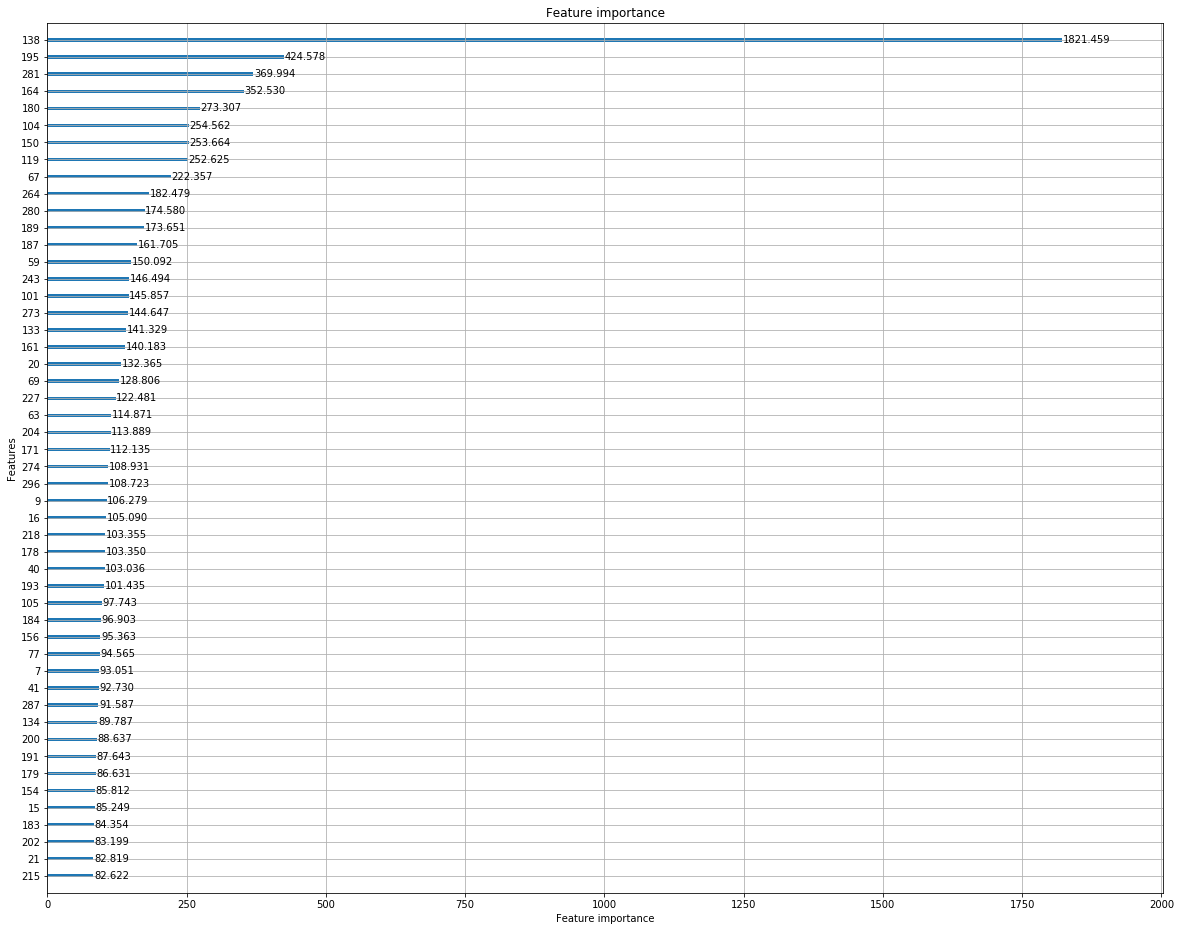

In [225]:
ax = lgb.plot_importance(gbm_count, importance_type='gain', max_num_features=50)
fig = ax.figure
fig.set_size_inches(20, 16)

In [226]:
gbm_count.best_iteration_

100

In [228]:
#lgb.create_tree_digraph(gbm_count,tree_index=99,orientation="vertical")

In [231]:
len(all_test['text'])

1061

In [232]:
len(all_test['text'].unique())

958

In [233]:
df_test = all_test.groupby('text').agg({
    'date_time': 'count',
    'label': max
}).reset_index()

In [234]:
df_test.columns = ['text', 'count', 'label']

In [236]:
text_embedding_test = pd.DataFrame(get_embed_features(df_test['text']))

In [237]:
features_with_count_test = pd.concat([text_embedding_test, df_test['count']], axis=1)

In [239]:
features_with_count_test.shape

(958, 301)

In [240]:
get_results(gbm_count, features_with_count_test, df_test['label'])

              precision    recall  f1-score   support

           0    0.81614   0.93343   0.87085       661
           1    0.78218   0.53199   0.63327       297

    accuracy                        0.80898       958
   macro avg    0.79916   0.73271   0.75206       958
weighted avg    0.80561   0.80898   0.79720       958



In [244]:
# previous
get_results(svc, all_test_features, all_test['label'])

              precision    recall  f1-score   support

           0    0.82078   0.89140   0.85463       709
           1    0.73540   0.60795   0.66563       352

    accuracy                        0.79736      1061
   macro avg    0.77809   0.74968   0.76013      1061
weighted avg    0.79245   0.79736   0.79193      1061



### 5. Text preprocessing

In [180]:
def new_result_preprocessing(replace_hash = False, split_alphanumeric = False):
    if replace_hash:
        all_train['text_processed'] = all_train['text'].apply(lambda x: text_processing(x, replace_hash=True))
    elif split_alphanumeric:
        all_train['text_processed'] = all_train['text'].apply(lambda x: text_processing(x, split_alphanumeric=True))
    else:
        all_train['text_processed'] = all_train['text'].apply(lambda x: text_processing(x))        
    
    all_train['text_processed'].fillna('', inplace =True)
    all_train['text_token'] = get_text_token(all_train['text_processed'])
    all_train['token_exist'] = all_train['text_token'].apply(lambda x: len(x) > 0)
    all_train_select = all_train[all_train['token_exist']]
    

    train_features = get_embedding(all_train_select['text_token'])
    svc = SVC()
    svc = CalibratedClassifierCV(svc) 
    svc.fit(train_features, all_train_select['label'])
    news_features = get_embed_features_from_df(news)
    pred = svc.predict_proba(news_features)
    get_results(svc, news_features, news['label'])
    return None

In [181]:
new_result_preprocessing(replace_hash = True)

              precision    recall  f1-score   support

           0    0.86770   0.95708   0.91020       466
           1    0.71429   0.42373   0.53191       118

    accuracy                        0.84932       584
   macro avg    0.79099   0.69041   0.72106       584
weighted avg    0.83671   0.84932   0.83377       584



In [182]:
new_result_preprocessing(split_alphanumeric = True)

              precision    recall  f1-score   support

           0    0.86770   0.95708   0.91020       466
           1    0.71429   0.42373   0.53191       118

    accuracy                        0.84932       584
   macro avg    0.79099   0.69041   0.72106       584
weighted avg    0.83671   0.84932   0.83377       584



In [183]:
pred = new_result_preprocessing()

              precision    recall  f1-score   support

           0    0.86770   0.95708   0.91020       466
           1    0.71429   0.42373   0.53191       118

    accuracy                        0.84932       584
   macro avg    0.79099   0.69041   0.72106       584
weighted avg    0.83671   0.84932   0.83377       584



#### investigation

In [126]:
all_train['text_hash'] = all_train['text'].apply(lambda x: text_processing(x, replace_hash=True))
all_train['text_split'] = all_train['text'].apply(lambda x: text_processing(x, split_alphanumeric=True))
all_train['text_url'] = all_train['text'].apply(lambda x: text_processing(x))

In [135]:
pd.set_option('display.max_colwidth', -1)

In [138]:
all_train['text_hash_token'] = get_text_token(all_train['text'].apply(lambda x: text_processing(x, replace_hash=True)))
all_train['text_split_token'] = get_text_token(all_train['text'].apply(lambda x: text_processing(x, split_alphanumeric=True)))
all_train['text_url_token'] = get_text_token(all_train['text'].apply(lambda x: text_processing(x)))

In [144]:
all_train[(all_train['text_hash_token'] != all_train['text_split_token']) | (all_train['text_hash_token'] != all_train['text_url_token']) | (all_train['text_split_token'] != all_train['text_url_token'])][['text', 'text_hash_token', 'text_split_token', 'text_url_token']]

,text,text_hash_token,text_split_token,text_url_token
63,bitfinex is a liar and a fraudster. i have never seen such a liar and a fake company in my life. you can steal our money and still make a statement here without being embarrassed. bitfinex is a liar and a fraudster.. bitfinex is a liar and a fraudster.\ni have never seen such a liar and a fake company in my life. you can steal our money and still make a statement here without being embarrassed. bitfinex is a liar and a fraudster. \nblock 498901 . 2017-12-12 .. https://btc.com/ee4c03d499b54db0606e048fefef86b3cac4720befae629819ba5e0db20d3629 \nadres 18pdbf6u2pbbrjygby5txlxmwpdmmrbvsg\n,"[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, block, hash]","[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, block]","[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, block]"
65,bitfinex is a liar and a fraudster. i have never seen such a liar and a fake company in my life. you can steal our money and still make a statement here without being embarrassed. bitfinex is a liar and a fraudster.social bfx you too... #546151]...#422206..#444167...#406908]...is it enough ????\nblock 498901 . 2017-12-12 .. https://btc.com/ee4c03d499b54db0606e048fefef86b3cac4720befae629819ba5e0db20d3629 adres 18pdbf6u2pbbrjygby5txlxmwpdmmrbvsg 0.04358961 btc,"[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, social, you, too, is, it, enough, block, hash]","[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, social, you, too, is, it, enough, block]","[is, liar, fraudster, have, never, seen, such, liar, fake, company, in, my, life, you, can, steal, our, money, still, make, statement, here, without, being, embarrassed, is, liar, fraudster, social, you, too, is, it, enough, block]"
237,"my coins were stolen !!!!!. someone converted my tesla coins to btc and then did the whitdraw for this wallet: 17yezm46udulejgdnjc3bh8jgtinakdzwu. everything was done without my authorization, without notification, without confirmation email. it sounds like little but it was all i had. i hope cryptopia will solve this situation soon, because from what i'm seeing, i'm not the only one who suffered this blow today.\n\n","[my, coins, were, stolen, someone, converted, my, tesla, coins, then, did, the, for, this, wallet, hash, everything, was, done, without, my, authorization, without, notification, without, confirmation, email, it, sounds, like, little, but, it, was, all, had, hope, will, solve, this, situation, soon, because, from, what, seeing, not, the, only, one, who, suffered, this, blow, today]","[my, coins, were, stolen, someone, converted, my, tesla, coins, then, did, the, for, this, wallet, bh, everything, was, done, without, my, authorization, without, notification, without, c

In [146]:
all_train[(all_train['text_hash_token'] != all_train['text_split_token']) | (all_train['text_hash_token'] != all_train['text_url_token']) | (all_train['text_split_token'] != all_train['text_url_token'])][['text', 'text_hash_token', 'text_split_token', 'text_url_token']].shape

(11, 4)

In [145]:
all_train[(all_train['text_split_token'] != all_train['text_url_token'])][['text', 'text_hash_token', 'text_split_token', 'text_url_token']]

,text,text_hash_token,text_split_token,text_url_token


In [190]:
all_train['text_token'] = get_text_token(all_train['text'])

In [191]:
all_train[(all_train['text_token'] != all_train['text_url_token'])][['text', 'text_url', 'text_token', 'text_url_token']]

,text,text_url,text_token,text_url_token
9,"internal 2x attack failed. external shitcoin pump in effect.. we see all the shitcoins are pumping from one exchange called bithumb in south korea which we all know roger is associated with.\n\nhe mad\n\nwhat's funny is he's only making normies/n00blets rich. and they're bound to wake up and convert to btc once they get w0ke. so he and jihan are just giving away free btc (from the extraordinary amount they're mining, over half of the hash power) to ppl in a grand elaborate scheme of redistribution of wealth they arent even smart enough to see. lol. god works in mysterious ways",internal 2x attack failed external shitcoin pump in effect we see all the shitcoins are pumping from one exchange called bithumb in south korea which we all know roger is associated with he madwhat s funny is he s only making normies n00blets rich and they re bound to wake up and convert to btc once they get w0ke so he and jihan are just giving away free btc from the extraordinary amount they re mining over half of the hash power to ppl in a grand elaborate scheme of redistribution of wealth they arent even smart enough to see lol god works in mysterious ways,"[internal, attack, failed, external, pump, in, effect, we, see, all, the, are, pumping, from, one, exchange, called, in, south, korea, which, we, all, know, roger, is, associated, with, he, mad, what, funny, is, he, only, making, normies, rich, they, re, bound, wake, up, convert, once, they, get, ke, so, he, are, just, giving, away, free, from, the, extraordinary, amount, they, re, mining, over, half, the, hash, power, ppl, in, grand, elaborate, scheme, redistribution, wealth, they, arent, even, smart, enough, see, lol, god, works, in, mysterious, ways]","[internal, attack, failed, external, pump, in, effect, we, see, all, the, are, pumping, from, one, exchange, called, in, south, korea, which, we, all, know, roger, is, associated, with, he, funny, is, he, only, making, normies, rich, they, re, bound, wake, up, convert, once, they, get, ke, so, he, are, just, giving, away, free, from, the, extraordinary, amount, they, re, mining, over, half, the, hash, power, ppl, in, grand, elaborate, scheme, redistribution, wealth, they, arent, even, smart, enough, see, lol, god, works, in, mysterious, ways]"
14,"beware of fake website as first search result/ bittrex acc hacked. if you are new to cryptotrading you dont always have the best security or experience. my friend searched for bittrex using google and clicked the first result. than he tried logging in and received a mail that someone logged in on his account. he realised that something was wrong. \n&amp;nbsp;&amp;nbsp;\n\n\nhe noticed that the website link was a bit different.\nhttps://imgur.com/a/skvgn\n&amp;nbsp;&amp;nbsp;\n\n\nhe logged in on the real website now and saw that all his coins were sold for btc. than the btc was send away. he tried to cancel it in pending modus but it wouldn't work. \nhttps://imgur.com/a/i0bk7\n&amp;nbsp;&amp;nbsp;\n\n\n*the first problem was that google gave a fake website as a first result.\n\n*also they could acces his account by using a new ip because the email adress and password combination was the same\n\n*third the 2factor was not enabled\n&amp;nbsp;\n&amp;nbsp;\n\n\nthe hackers created a 2factor on his account and as result he cant login anymore. everything happened in a manner of minutes. \n&amp;nbsp;&amp;nbsp;\ni looked for thing he could do to receive his money back, but i dontt think that there is anything that can resolve this. it was a big amount for people like him and me.\n&amp;nbsp;&amp;nbsp;\n\n\n&amp;nbsp;&amp;nbsp;\ni hope this can help some people in the future. \n",beware of fake website as first search result bittrex acc hacked if you are new to cryptotrading you dont always have the best security or experience my friend searched for bittrex using google and clicked the first result than he tried logging in and received a mail that someone logged in on h

### 6. Downsample negative cases

In [13]:
all_train.label.value_counts()

0    2910
1    1383
Name: label, dtype: int64

In [14]:
all_train_1 = all_train[all_train.label == 1]

In [16]:
all_train_0_under = all_train[all_train.label == 0].sample(n=len(all_train_1), random_state = 2020)

In [18]:
all_train_b = pd.concat([all_train_1, all_train_0_under], axis=0)

In [19]:
all_train_b.shape

(2766, 4)

In [21]:
train_features_b = get_embed_features(all_train_b['text'])

In [31]:
svc_b = SVC()
svc_b = CalibratedClassifierCV(svc_b) 
svc_b.fit(train_features_b, all_train_b['label'])

CalibratedClassifierCV(base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

In [32]:
news_features = get_embed_features(news['text'])

In [34]:
# svm balanced training
get_results(svc_b, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.95082   0.87124   0.90929       466
           1    0.61783   0.82203   0.70545       118

    accuracy                        0.86130       584
   macro avg    0.78433   0.84664   0.80737       584
weighted avg    0.88354   0.86130   0.86811       584



## Final model: remove url, downsample negative cases

In [36]:
def get_embed_features_from_df(df):
    df['text_processed'] = df['text'].apply(lambda x: text_processing(x))
    df['text_processed'].fillna('', inplace =True)
    df['text_token'] = get_text_token(df['text_processed'])
    df['token_exist'] = df['text_token'].apply(lambda x: len(x) > 0)
    df_select = df[df['token_exist']]
    return get_embedding(df_select['text_token'])

In [35]:
all_train_b['text_processed'] = all_train_b['text'].apply(lambda x: text_processing(x))
all_train_b['text_processed'].fillna('', inplace =True)
all_train_b['text_token'] = get_text_token(all_train_b['text_processed'])
all_train_b['token_exist'] = all_train_b['text_token'].apply(lambda x: len(x) > 0)
all_train_b_select = all_train_b[all_train_b['token_exist']]


train_features_b = get_embedding(all_train_b_select['text_token'])
svc_final = SVC()
svc_final = CalibratedClassifierCV(svc_final) 
svc_final.fit(train_features_b, all_train_b_select['label'])

CalibratedClassifierCV(base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

In [38]:
news_features = get_embed_features_from_df(news)
get_results(svc_final, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.95249   0.86052   0.90417       466
           1    0.60123   0.83051   0.69751       118

    accuracy                        0.85445       584
   macro avg    0.77686   0.84551   0.80084       584
weighted avg    0.88152   0.85445   0.86241       584



In [44]:
rd_features = get_embed_features_from_df(rd)
get_results(svc_final, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.69231   0.55385   0.61538       195
           1    0.60811   0.73770   0.66667       183

    accuracy                        0.64286       378
   macro avg    0.65021   0.64578   0.64103       378
weighted avg    0.65154   0.64286   0.64021       378



In [46]:
tt_features = get_embed_features_from_df(tt)
get_results(svc_final, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.90385   0.97917   0.94000        48
           1    0.97872   0.90196   0.93878        51

    accuracy                        0.93939        99
   macro avg    0.94128   0.94056   0.93939        99
weighted avg    0.94242   0.93939   0.93937        99



In [47]:
all_test_features = get_embed_features_from_df(all_test)
get_results(svc_final, all_test_features, all_test['label'])

              precision    recall  f1-score   support

           0    0.88394   0.78420   0.83109       709
           1    0.64583   0.79261   0.71173       352

    accuracy                        0.78699      1061
   macro avg    0.76489   0.78841   0.77141      1061
weighted avg    0.80495   0.78699   0.79149      1061



# -----

## training

In [11]:
all_train = pd.read_csv('../data/final_0923/all_train.csv', index_col = 0)

In [140]:
train_features = get_embed_features(all_train['text'])

In [74]:
train_features.shape

(4293, 300)

### - svm

In [141]:
from sklearn.calibration import CalibratedClassifierCV

In [142]:
svc = SVC()
svc = CalibratedClassifierCV(svc) 
svc.fit(train_features, all_train['label'])

CalibratedClassifierCV(base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma='scale', kernel='rbf',
                                          max_iter=-1, probability=False,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       cv=None, method='sigmoid')

In [41]:
pickle.dump(svc, open('svm_1013.txt', 'wb'))

### - lightGBM

In [82]:
clf = lgb.LGBMClassifier()

In [87]:
train_features, val_features, train_y, val_y = train_test_split(train_features, all_train['label'], random_state=4222)

In [89]:
gbm = clf.fit(X=train_features, 
              y=train_y,
              eval_set=[(val_features, val_y)],
              eval_metric=['auc', 'binary_logloss'],
              early_stopping_rounds=50, 
              verbose=True)

[1]	valid_0's auc: 0.792534	valid_0's binary_logloss: 0.589081
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.812303	valid_0's binary_logloss: 0.562837
[3]	valid_0's auc: 0.811909	valid_0's binary_logloss: 0.543352
[4]	valid_0's auc: 0.816088	valid_0's binary_logloss: 0.525586
[5]	valid_0's auc: 0.818476	valid_0's binary_logloss: 0.511651
[6]	valid_0's auc: 0.820551	valid_0's binary_logloss: 0.499509
[7]	valid_0's auc: 0.823605	valid_0's binary_logloss: 0.488807
[8]	valid_0's auc: 0.829781	valid_0's binary_logloss: 0.478446
[9]	valid_0's auc: 0.834591	valid_0's binary_logloss: 0.468999
[10]	valid_0's auc: 0.835823	valid_0's binary_logloss: 0.462119
[11]	valid_0's auc: 0.841548	valid_0's binary_logloss: 0.453749
[12]	valid_0's auc: 0.844061	valid_0's binary_logloss: 0.447497
[13]	valid_0's auc: 0.844749	valid_0's binary_logloss: 0.442022
[14]	valid_0's auc: 0.844427	valid_0's binary_logloss: 0.438363
[15]	valid_0's auc: 0.847062	valid_0's binary_loglos

## testing

### - news

In [28]:
news = pd.read_csv('../data/final_0923/news_test.csv', index_col = 0)

In [144]:
news_features = get_embed_features(news['text'])

In [28]:
# logistic regression
get_results(lr, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.85878   0.96567   0.90909       466
           1    0.73333   0.37288   0.49438       118

    accuracy                        0.84589       584
   macro avg    0.79606   0.66927   0.70174       584
weighted avg    0.83343   0.84589   0.82530       584



In [29]:
# svm
get_results(svc, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86372   0.96567   0.91185       466
           1    0.74603   0.39831   0.51934       118

    accuracy                        0.85103       584
   macro avg    0.80488   0.68199   0.71560       584
weighted avg    0.83994   0.85103   0.83254       584



In [112]:
# lightGBM
get_results(gbm, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86590   0.96996   0.91498       466
           1    0.77419   0.40678   0.53333       118

    accuracy                        0.85616       584
   macro avg    0.82005   0.68837   0.72416       584
weighted avg    0.84737   0.85616   0.83787       584



In [145]:
# svm
get_results(svc, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.86965   0.95923   0.91224       466
           1    0.72857   0.43220   0.54255       118

    accuracy                        0.85274       584
   macro avg    0.79911   0.69572   0.72740       584
weighted avg    0.84114   0.85274   0.83755       584



In [30]:
# random forest
get_results(rf, news_features, news['label'])

              precision    recall  f1-score   support

           0    0.84601   0.97854   0.90746       466
           1    0.77778   0.29661   0.42945       118

    accuracy                        0.84075       584
   macro avg    0.81189   0.63758   0.66846       584
weighted avg    0.83222   0.84075   0.81088       584



### - reddit

In [40]:
rd = pd.read_csv('../data/final_0923/reddit_test.csv', index_col = 0)

In [14]:
rd_features = get_embed_features(rd['text'])

#### all_model

In [34]:
# logistic regression
get_results(lr, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.66816   0.76410   0.71292       195
           1    0.70323   0.59563   0.64497       183

    accuracy                        0.68254       378
   macro avg    0.68569   0.67987   0.67894       378
weighted avg    0.68514   0.68254   0.68002       378



In [35]:
# svm
get_results(svm, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.67105   0.78462   0.72340       195
           1    0.72000   0.59016   0.64865       183

    accuracy                        0.69048       378
   macro avg    0.69553   0.68739   0.68603       378
weighted avg    0.69475   0.69048   0.68721       378



In [107]:
# lightGBM
get_results(gbm, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.67606   0.73846   0.70588       195
           1    0.69091   0.62295   0.65517       183

    accuracy                        0.68254       378
   macro avg    0.68348   0.68071   0.68053       378
weighted avg    0.68325   0.68254   0.68133       378



In [36]:
# random forest
get_results(rf, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.64407   0.77949   0.70534       195
           1    0.69718   0.54098   0.60923       183

    accuracy                        0.66402       378
   macro avg    0.67063   0.66024   0.65728       378
weighted avg    0.66978   0.66402   0.65881       378



#### reddit_model

In [15]:
# logistic regression
get_results(rd_lr, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.66250   0.81538   0.73103       195
           1    0.73913   0.55738   0.63551       183

    accuracy                        0.69048       378
   macro avg    0.70082   0.68638   0.68327       378
weighted avg    0.69960   0.69048   0.68479       378



In [16]:
# svm
get_results(rd_svm, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.66531   0.83590   0.74091       195
           1    0.75940   0.55191   0.63924       183

    accuracy                        0.69841       378
   macro avg    0.71235   0.69391   0.69007       378
weighted avg    0.71086   0.69841   0.69169       378



In [17]:
# random forest
get_results(rd_rf, rd_features, rd['label'])

              precision    recall  f1-score   support

           0    0.62846   0.81538   0.70982       195
           1    0.71200   0.48634   0.57792       183

    accuracy                        0.65608       378
   macro avg    0.67023   0.65086   0.64387       378
weighted avg    0.66890   0.65608   0.64597       378



### - twitter

In [41]:
tt = pd.read_csv('../data/final_0923/twitter_test.csv', index_col = 0)

In [110]:
tt_features = get_embed_features(tt['text'])

In [20]:
# logistic regression
get_results(lr, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.75000   1.00000   0.85714        48
           1    1.00000   0.68627   0.81395        51

    accuracy                        0.83838        99
   macro avg    0.87500   0.84314   0.83555        99
weighted avg    0.87879   0.83838   0.83489        99



In [22]:
# svm
get_results(svm, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.84211   1.00000   0.91429        48
           1    1.00000   0.82353   0.90323        51

    accuracy                        0.90909        99
   macro avg    0.92105   0.91176   0.90876        99
weighted avg    0.92344   0.90909   0.90859        99



In [111]:
# lightGBM
get_results(gbm, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.82759   1.00000   0.90566        48
           1    1.00000   0.80392   0.89130        51

    accuracy                        0.89899        99
   macro avg    0.91379   0.90196   0.89848        99
weighted avg    0.91641   0.89899   0.89826        99



In [24]:
# random forest
get_results(rf, tt_features, tt['label'])

              precision    recall  f1-score   support

           0    0.76190   1.00000   0.86486        48
           1    1.00000   0.70588   0.82759        51

    accuracy                        0.84848        99
   macro avg    0.88095   0.85294   0.84623        99
weighted avg    0.88456   0.84848   0.84566        99



### - all

In [42]:
all_test = pd.read_csv('../data/final_0923/all_test.csv', index_col = 0)

In [242]:
all_test_features = get_embed_features(all_test['text'])

In [39]:
# logistic regression
get_results(lr, all_test_features, all_test['label'])

              precision    recall  f1-score   support

           0    0.79778   0.91255   0.85132       709
           1    0.75200   0.53409   0.62458       352

    accuracy                        0.78699      1061
   macro avg    0.77489   0.72332   0.73795      1061
weighted avg    0.78259   0.78699   0.77609      1061



In [40]:
# svm
get_results(svm, all_test_features, all_test['label'])

              precision    recall  f1-score   support

           0    0.80769   0.91819   0.85941       709
           1    0.77255   0.55966   0.64909       352

    accuracy                        0.79925      1061
   macro avg    0.79012   0.73893   0.75425      1061
weighted avg    0.79603   0.79925   0.78963      1061



In [41]:
# random forest
get_results(rf, all_test_features, all_test['label'])

              precision    recall  f1-score   support

           0    0.78282   0.92525   0.84809       709
           1    0.76233   0.48295   0.59130       352

    accuracy                        0.77851      1061
   macro avg    0.77257   0.70410   0.71970      1061
weighted avg    0.77602   0.77851   0.76290      1061

